## W&B x JAX Meetup Series Notebook #1 

This is notebook 1 from the JAX Study Group. To credit, this notebook was created by [Cristian Garcia](https://twitter.com/cgarciae88) with some additions made by [Sanyam Bhutani](http://twitter.com/bhutanisanyam1). 

To join the study group, please register for the Zoom webinar [here](http://wandb.me/JAX-registration) and join the JAX meetup page [here](https://www.meetup.com/jax-global-meetup/)

Note: All meetups will be recorded and materials will be made available on the [forums](https://community.wandb.ai/c/community-events/jax/41)


## Content Outline:

- JAX vs Numpy
- Automatic Differentiation
- Vectorization
- JIT Compilation
- Parallelization
- PyTrees


## Setup
During this tutorial we are going to use Jax with a TPU to showcase some of its features, to do this go to `Runtime > Change runtime type` and select `TPU`. After that just run the following cell:

In [1]:
import jax

#Uncomment these lines for TPU:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

For TPU,
If all went well you should see `8` devices.

Note:
You should see a GPU ID if you're trying this w GPU

## Numpy API
[`Numpy`]() is the bread and butter of all MLEs toolbox. 

Jax's primary "tensor" abtraction and API is good old Numpy array and the Numpy API which is available as `jax.numpy`. 



In [2]:
import numpy as np

#Jax offers a `jax.numpy` API
import jax.numpy as jnp

Let's take a peek at the function differences, as we'll see from the output, almost the entirity of the functions supported by `numpy` are present in `jax.numpy`

In [3]:
np_funcs = set(dir(np))
jnp_funcs = set(dir(jnp))

print(len(np_funcs)  , len(jnp_funcs.intersection(np_funcs)))

622 474


In [4]:
print(np_funcs.difference(jnp_funcs))

{'NAN', 'ushort', 'bytes_', 'warnings', 'char', 'ufunc', 'flatiter', 'rec', 'format_parser', 'FLOATING_POINT_SUPPORT', 'ulonglong', 'FPE_UNDERFLOW', 'True_', '_distributor_init', 'SHIFT_INVALID', 'str_', 'longlong', '__git_revision__', 'cfloat', 'sctypeDict', 'ndenumerate', 'MAY_SHARE_EXACT', 'byte', 'FPE_OVERFLOW', 'numarray', 'PINF', 'poly1d', 'short', 'TooHardError', 'clongdouble', '_mat', 'VisibleDeprecationWarning', 'ScalarType', 'dual', 'typeDict', 'emath', 'uintp', 'ERR_WARN', 'uint', 'MAY_SHARE_BOUNDS', 'False_', 'longcomplex', 'string_', 'float', 'ERR_PRINT', 'object', 'broadcast', '__NUMPY_SETUP__', 'long', 'compat', 'intp', 'use_hugepage', 'ERR_RAISE', 'SHIFT_DIVIDEBYZERO', 'MachAr', 'ERR_DEFAULT', 'nbytes', 'ERR_LOG', 'random', 'chararray', '_NoValue', 'ctypeslib', 'sctypeNA', 'str', '_globals', 'bool', 'sctypes', 'void', 'FPE_DIVIDEBYZERO', 'bytes0', 'RAISE', 'tracemalloc_domain', 'BUFSIZE', 'busdaycalendar', 'Infinity', 'SHIFT_OVERFLOW', 'version', 'half', '_UFUNC_API', '

This is one of its best features because its familiar to almost everyone on the field, take a look at the following example:

In [5]:
?jnp.meshgrid()

In [6]:
x = jnp.linspace(0, 1, 100)
y = jnp.linspace(0, 10, 100)

X, Y = jnp.meshgrid(x, y)

print("X:", X.shape)
print("Y:", Y.shape)

X: (100, 100)
Y: (100, 100)


## Reminder: JAX ~= Numpy on Accelerators

In [7]:
#Source: JAX ReadMe

import jax.numpy as jnp
from jax import grad, jit, vmap

def predict(params, inputs):
  for W, b in params:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.tanh(outputs)  # inputs to the next layer
  return outputs                # no activation on last layer

def loss(params, inputs, targets):
  preds = predict(params, inputs)
  return jnp.sum((preds - targets)**2)

grad_loss = jit(grad(loss))  # compiled gradient evaluation function
perex_grads = jit(vmap(grad_loss, in_axes=(None, 0, 0)))  # fast per-example grads


## Differences:

Credit: [JAX Sharp Bits Colab by JAX Team](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Common_Gotchas_in_JAX.ipynb#scrollTo=om4xV7_84N9j)
- In place modify doesn't work
- `jnp.random` doesn't exist! You have to use `jax.random` which offers the same functions **BUT** it is you have to explicitly handle the random state (RNG) that is compatible with Jax's functional programming model.
- Updated Array is a new Array
- Out of place updates
- Non Array Inputs
- Using `double`

In [8]:
numpy_array = np.zeros((3,3), dtype=np.float32)
print("original array:")
print(numpy_array)

# In place, mutating update
numpy_array[1, :] = 1.0
print("updated array:")
print(numpy_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array:
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [9]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)

# JAX Arrays are immutable
try:
  jax_array[1, :] = 1.0
except Exception as e:
  print("Exception {}".format(e))

Exception '<class 'jax.interpreters.xla._DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/jax.ops.html


In [10]:
updated_array = jax_array.at[1, :].set(1.0)
print("updated array:\n", updated_array)

print("original array unchanged:\n", jax_array)

updated array:
 [[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
original array unchanged:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [11]:
from jax import random
key = random.PRNGKey(0)
key

print(random.normal(key, shape=(1,)))

[-0.20584236]


In [14]:
print((jnp.arange(10)[100]))

9


In [15]:
try:
  jnp.sum([1, 2, 3])
except TypeError as e:
  print(f"TypeError: {e}")

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [16]:
x = random.uniform(random.PRNGKey(0), (1000,), dtype=jnp.float64)
x.dtype

dtype('float32')

In [17]:
#Do this to enable higher precision:
from jax.config import config
config.update("jax_enable_x64", False)

Apart from the `numpy` API has a suite of function transformations which let you easily perform computations that can be hard on other frameworks. We will these transformations next!

## Automatic Differentiation
One of the most important aspects of a modern Linear Algebra library is Automatic Differentiation. To explore how Jax achieves this lets first view a simple example of the density function of the normal distribution which has the form:

$$ 
f(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right) 
$$

This is available in Jax as `jax.scipy.stats.norm.pdf` and behaves just like its Scipy counterpart:

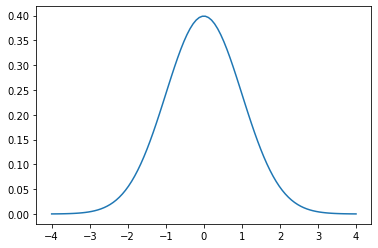

In [18]:
import matplotlib.pyplot as plt

x = jnp.linspace(-4, 4, 100)
y = jax.scipy.stats.norm.pdf(x)

plt.plot(x, y);

Here we used the default parameters \\( {\mu} = 0 \\) and \\( {\sigma} = 1 \\). Now if we wanted its derivative we could probably get an exact expressionby hand but in Jax we can leverage the `grad` function which will transform our function into a function that returns its gradient:

In [19]:
grad_fn = jax.grad(jax.scipy.stats.norm.pdf)

{
  -5.0: grad_fn(-5.0), 
  -1.0: grad_fn(-1.0),
   0.0: grad_fn(0.0), 
   1.0: grad_fn(1.0), 
   5.0: grad_fn(5.0)
}

{-5.0: DeviceArray(7.433706e-06, dtype=float32),
 -1.0: DeviceArray(0.24197444, dtype=float32),
 0.0: DeviceArray(-0., dtype=float32),
 1.0: DeviceArray(-0.24197444, dtype=float32),
 5.0: DeviceArray(-7.433706e-06, dtype=float32)}

Here we evaluated the derivative of the density function at five points which match our intuition about the functions behavious: almost `0` at `-5`, positive at `-1`, flat at `0`, netative at `-1`, and then almost `0` at `-5`. As its common in Numpy, We could be tempted to calculate this for the whole domain but we will get an error:

In [20]:
try:
  dydx = grad_fn(x)
except BaseException as e:
  print(e)

Gradient only defined for scalar-output functions. Output had shape: (100,).


As the message points out, the gradient of a function is only defined for a scalar output and here we are returning a vector. To solve this we can explore vectorization.

## Vectorization
Jax provides a function called `vmap` which lets us transform a function that works with arrays without an explicit batch dimension into a function that now accepts arrays with a batch dimension. Very loosely we are performing the following transformation:
```
(a...) -> (b...) => (batch, a...) -> (batch, b...)
```
Notice how `batch` pops-up in the shapes of the resulting function. For our use-case, since our `grad_fn` only operates on scalars, we can _simply_ use `vmap` to make it work on vectors:

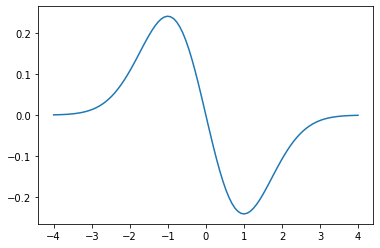

In [21]:
vectorized_grad_fn = jax.vmap(jax.grad(jax.scipy.stats.norm.pdf))

plt.plot(x, vectorized_grad_fn(x));

Nice! This is very useful in practice if you want to get per-sample gradients which has some known applications.

## JIT Compilation
Lets now switch to the area of performance by creating a function we will call `n_dots` that will iteratively call the `dot` function `1000` times over our input `x` by applying `w`:

In [22]:
def n_dots(x, w):
  for i in range(200):
    a = jnp.dot(x, w) + x
    x = jnp.dot(x, a.mean(axis=[0, 1]))
  return x

We will first create some random matrices using `jax.random`:

In [23]:
key = jax.random.PRNGKey(42)
key1, key2 = jax.random.split(key, 2)

x = jax.random.uniform(key1, shape=(8, 10, 256, 256))
w = jax.random.uniform(key2, shape=(256, 256))

Notice how we derived 2 random keys `key1` and `key2` by splitting a base key, and we feed these keys to the `uniform` function. Using these arrays we can now benchmark `n_dots` with `timeit`: 



In [24]:
%timeit n_dots(x, w).block_until_ready()

1 loop, best of 5: 1.5 s per loop


Notice that we use `.block_until_ready()`, this is needed because Jax has an asynchronous model that queues computation the devices in the background and returns almost inmediately which would be misleading.

Now the previous computation is quite slow in part because of the Python interpreter but also because Jax's eager mode is not optimized. We can do a lot better if we compile the whole computation into a single XLA program via the `jit` transformation:

In [25]:
n_dots_jit = jax.jit(n_dots)

n_dots_jit(x, w) # benchmark trick
print("done jitting")

%timeit n_dots_jit(x, w).block_until_ready()

done jitting
10 loops, best of 5: 67.4 ms per loop


This is more than a **10x** improvement 🚀. This is amazing but can we do better?

## Parallelization

`vmap` allows parallelization on a single device

`pmap` allows parallelization across multiple devices. Ex: TPU Cores.

In [26]:
n_dots_pmap = jax.pmap(n_dots, in_axes=(0, None))

n_dots_pmap(x, w)
print("done jitting")

%timeit n_dots_pmap(x, w).block_until_ready()

done jitting
100 loops, best of 5: 12.7 ms per loop


This is an extra **5x** over `jit` 🚀🚀🚀. Notice that we use `in_axes=(0, None)` This means that we are slicing over the first dimension of the first input `x` but not slicing (replicating) the second input `w`.

## Pytrees
Jax offers the concept of a Pytree which is extreemly useful to manimulate complex states, this become important as you do more complex stuff since Jax is very explicit about state handling because of its functional design. 

We can loosely define a `Pytree` as **any structure which can be flattened**.  Lets create a simple example of such a structure:

In [27]:
tree = {"a": [1.0, 2.0], "b": (3.0, {"c": 4.0, "d": 5.0})}
tree

{'a': [1.0, 2.0], 'b': (3.0, {'c': 4.0, 'd': 5.0})}

Here we used dictionaries, lists and tuples to create a nested structure, we can also define register our custom types as pytrees but we will not cover this here. Now, flattening this pytree would be a tipical interview question but Jax lets us do this easily by using the `tree_leaves` function:

In [28]:
jax.tree_leaves(tree)

[1.0, 2.0, 3.0, 4.0, 5.0]

We can also map over a pytree by using the `tree_map` function which behaves a bit like `map` but keeps the shape of the original structure:

In [29]:
jax.tree_map(lambda x: 10 * x, tree)

{'a': [10.0, 20.0], 'b': (30.0, {'c': 40.0, 'd': 50.0})}

Here we multiplied each leaf element by `10`. We can also leaf-wise operations between 2 pytrees if they have the same structure:

In [30]:
jax.tree_map(lambda x, y: x * y, tree, tree)

{'a': [1.0, 4.0], 'b': (9.0, {'c': 16.0, 'd': 25.0})}

Here we multiplied the elements between 2 pytrees, for simplicity we just reused `tree` but this works in general. 

Ok, this is very cool but why do we really care about this? The reason most of the basic transformations in Jax and many of the libraries support pytrees. To see this lets do something a bit strange, lets create a loss function our our tree structure:

In [31]:
def tree_loss(tree):
  return sum((x ** 2 for x in jax.tree_leaves(tree)), 0.0)

tree_loss(tree)

55.0

To define this loss function we leverages `tree_leaves` to square each element before adding them up using `sum`. The next obvious step is seen if we can define can calculate the gradient for our loss function for this tree:

In [32]:
tree_grad = jax.grad(tree_loss)

# tree_grad(tree)
jax.tree_map(float, tree_grad(tree))

{'a': [2.0, 4.0], 'b': (6.0, {'c': 8.0, 'd': 10.0})}

An it works just fine! Notice that the gradient of the loss has the same shape as our tree 😄. Putting everything together we can perform gradient descent to get the minimum tree by using `jit` and `tree_multimap`:

In [33]:
tree_min = tree

def gradient_descent(p, g):
  return p - 0.1 * g

@jax.jit
def update(tree):
    grads = tree_grad(tree)
    tree = jax.tree_map(gradient_descent, tree, grads) #GD
    return tree

for i in range(100):
    tree_min = update(tree_min)

jax.tree_map(float, tree_grad(tree_min))

{'a': [4.074073578497206e-10, 8.148147156994412e-10],
 'b': (1.2222216572155276e-09,
  {'c': 1.6296294313988824e-09, 'd': 2.0370367614930274e-09})}

Beautiful! The optimal solution is all zeros so we are very close.